# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_2760.csv')
df.head(10)

,content,sentimen
0,calon presiden capres anies baswedan menyinggu...,negatif
1,warga kecamatan tanjung bintang kabupaten lamp...,negatif
2,mobil berpelat nomor kedutaan negeri dilaporka...,negatif
3,majelis kehormatan mk memutuskan anwar usman d...,negatif
4,2 motor ruang publik terpadu ramah anak rptra ...,negatif
5,ketua fraksi demokrat dpr ri edhie baskoro yud...,negatif
6,dinas pemadam kebakaran penyelamatan kota depo...,negatif
7,calon presiden bacapres ganjar pranowo menangg...,negatif
8,ketua tim hukum nasional amin ari yusuf menyes...,negatif
9,kanit reskrim polsek pesanggrahan iptu adit ke...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 140468
Jumlah fitur Bag of Words: 18889
Jumlah fitur gabungan: 159357


### Model Naiye Bayes

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Tanpa Parameter

In [11]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(model_naiye_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [12]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 80.92%
F1 Score: 80.75%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.74      0.79       272
      netral       0.85      0.75      0.80       280
     positif       0.76      0.93      0.84       276

    accuracy                           0.81       828
   macro avg       0.82      0.81      0.81       828
weighted avg       0.82      0.81      0.81       828

Confusion Matrix:
 [[201  27  44]
 [ 30 211  39]
 [  7  11 258]]


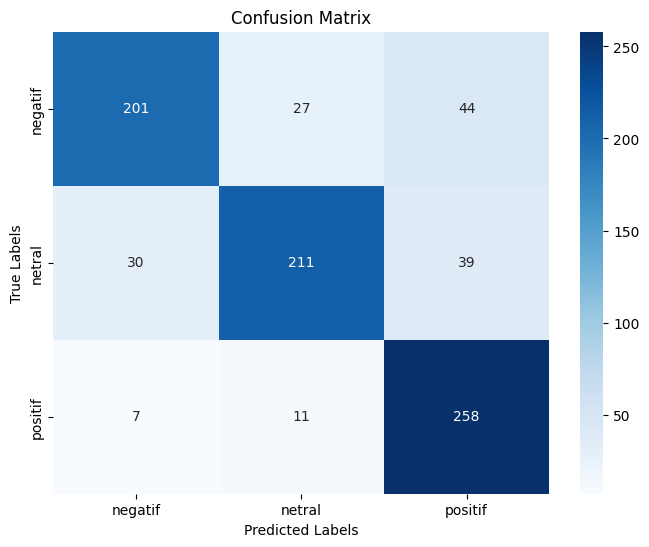

In [13]:
# Plot confusion matrix
plot_confusion_matrix(tfidf_matrix, label_encoder.classes_)

In [14]:
test = ('Jeka Saragih On Fire Menatap Debut di UFC')
line = tfidf_vectorizer.transform([test])
line.shape
test_result = model_naiye_tanpa_parameter.predict(line)
predicted_label = label_encoder.inverse_transform(test_result)
print("Hasil Prediksi:", predicted_label)

Hasil Prediksi: ['netral']


#### Tuning

In [15]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid = {
#     'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Parameter alpha untuk smoothing
#     'fit_prior': [True, False]            # Opsional, apakah akan mempelajari probabilitas prior atau tidak
# }

# # Buat objek GridSearchCV
# grid_search = GridSearchCV(model_naiye_tanpa_parameter, param_grid, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# # Evaluasi model dengan parameter terbaik
# best_model = grid_search.best_estimator_
# accuracy, f1, _, _ = train_and_evaluate(best_model, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)
# print("Best Parameters:", best_model)
# print("Accuracy (Best Model):", accuracy)
# print("F1 Score (Best Model):", f1)

#### Pakai Paramater

In [16]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha=0.1,fit_prior=True)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(model_naiye_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [17]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 82.49%
F1 Score: 82.36%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.80      0.82       272
      netral       0.86      0.75      0.80       280
     positif       0.78      0.93      0.85       276

    accuracy                           0.82       828
   macro avg       0.83      0.83      0.82       828
weighted avg       0.83      0.82      0.82       828

Confusion Matrix:
 [[217  21  34]
 [ 32 210  38]
 [  8  12 256]]


### Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Paramater

In [19]:
# Initialize Naive Bayes classifier
svm_tanpa_parameter = SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(svm_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [20]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 87.92%
F1 Score: 87.91%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.86      0.86      0.86       272
      netral       0.89      0.86      0.87       280
     positif       0.88      0.92      0.90       276

    accuracy                           0.88       828
   macro avg       0.88      0.88      0.88       828
weighted avg       0.88      0.88      0.88       828

Confusion Matrix:
 [[234  19  19]
 [ 25 241  14]
 [ 12  11 253]]


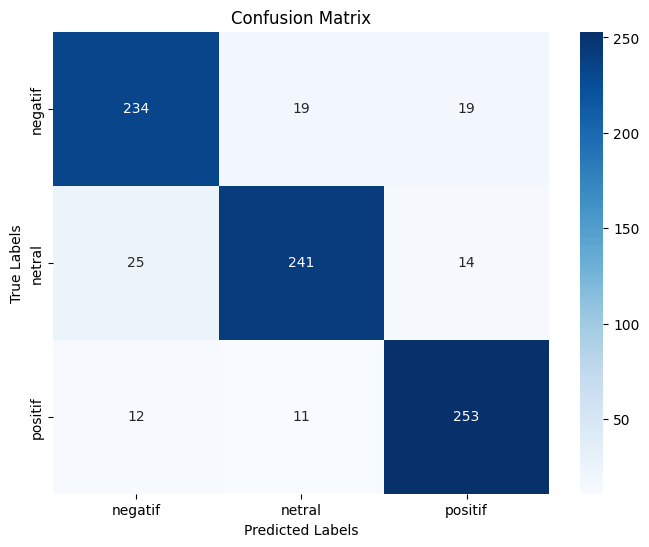

In [21]:
# Plot confusion matrix
plot_confusion_matrix(tfidf_matrix, label_encoder.classes_)

#### Tuning

In [22]:
# # Tentukan parameter grid yang akan dieksplorasi
# svm_param_grid = {
#     'C': [0.1, 1, 10, 100],            # Parameter regulasi (cost)
#     'kernel': ['linear', 'rbf'],       # Kernel yang digunakan
#     'gamma': ['scale', 'auto'],        # Koefisien kernel untuk 'rbf'
# }

# # Buat objek GridSearchCV
# svm_grid_search = GridSearchCV(svm_tanpa_parameter, svm_param_grid, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# svm_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# svm_best_params = svm_grid_search.best_params_
# svm_best_score = svm_grid_search.best_score_

# print("Best Parameters:", svm_best_params)
# print("Best Score:", svm_best_score)

# # Evaluasi model dengan parameter terbaik
# svm_best_model = svm_grid_search.best_estimator_
# svm_accuracy, svm_f1, _, _ = train_and_evaluate(svm_best_model, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# print("Best Parameters:", svm_best_model)
# print("Accuracy (Best Model):", svm_accuracy)
# print("F1 Score (Best Model):", svm_f1)

#### Pakai Parameter

In [23]:
# Initialize Naive Bayes classifier
svm_parameter = SVC(C=10,gamma='scale',kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(svm_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [24]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 88.77%
F1 Score: 88.75%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.87      0.89      0.88       272
      netral       0.90      0.85      0.88       280
     positif       0.90      0.92      0.91       276

    accuracy                           0.89       828
   macro avg       0.89      0.89      0.89       828
weighted avg       0.89      0.89      0.89       828

Confusion Matrix:
 [[242  16  14]
 [ 26 239  15]
 [ 11  11 254]]


### Model Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Paramater

In [26]:
# Initialize Naive Bayes classifier
lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(lr_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [27]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 85.27%
F1 Score: 85.21%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.82      0.83       272
      netral       0.88      0.82      0.85       280
     positif       0.84      0.92      0.88       276

    accuracy                           0.85       828
   macro avg       0.85      0.85      0.85       828
weighted avg       0.85      0.85      0.85       828

Confusion Matrix:
 [[222  20  30]
 [ 31 231  18]
 [ 10  13 253]]


#### Tuning

In [28]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid_logistic = {
#     'C': [0.1, 0.5, 1.0, 2.0, 5.0],   # Invers dari kekuatan regularisasi
#     'penalty': ['l1', 'l2'],           # Jenis regularisasi: Lasso (l1) atau Ridge (l2)
#     'solver': ['liblinear', 'saga'],  # Algoritma solver: liblinear atau saga (cocok untuk regularisasi L1)
#     'max_iter': [1000]        # Jumlah iterasi maksimum
# }

# # Buat objek GridSearchCV untuk Logistic Regression
# logistic_grid_search = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# logistic_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params_logistic = logistic_grid_search.best_params_
# best_score_logistic = logistic_grid_search.best_score_

# print("Best Parameters (Logistic Regression):", best_params_logistic)
# print("Best Score (Logistic Regression):", best_score_logistic)

# # Evaluasi model Logistic Regression dengan parameter terbaik
# best_model_logistic = logistic_grid_search.best_estimator_
# accuracy_logistic, f1_logistic, _, _ = train_and_evaluate(best_model_logistic, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)
# print("Best Parameters:", best_model_logistic)
# print("Accuracy (Best Model - Logistic Regression):", accuracy_logistic)
# print("F1 Score (Best Model - Logistic Regression):", f1_logistic)

#### Parameter

In [29]:
# Initialize Naive Bayes classifier
lr_parameter = LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='liblinear')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(lr_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [30]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 89.73%
F1 Score: 89.72%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.90      0.88      0.89       272
      netral       0.89      0.88      0.88       280
     positif       0.90      0.93      0.92       276

    accuracy                           0.90       828
   macro avg       0.90      0.90      0.90       828
weighted avg       0.90      0.90      0.90       828

Confusion Matrix:
 [[239  20  13]
 [ 19 246  15]
 [  7  11 258]]


### Model Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Paramater

In [32]:
# Initialize Naive Bayes classifier
rfc_tanpa_parameter = RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(rfc_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [33]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 86.59%
F1 Score: 86.40%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.75      0.82       272
      netral       0.84      0.95      0.90       280
     positif       0.85      0.89      0.87       276

    accuracy                           0.87       828
   macro avg       0.87      0.86      0.86       828
weighted avg       0.87      0.87      0.86       828

Confusion Matrix:
 [[204  31  37]
 [  8 267   5]
 [ 12  18 246]]


#### Tuning

In [34]:
# # Tentukan parameter grid yang akan dieksplorasi
# param_grid_random_forest = {
#     'n_estimators': [50, 100, 200],      # Jumlah pohon keputusan dalam model
#     'max_depth': [None, 10, 20, 30],      # Maksimum kedalaman setiap pohon keputusan
#     'min_samples_split': [2, 5, 10],      # Jumlah sampel minimum yang dibutuhkan untuk membagi node internal
#     'min_samples_leaf': [1, 2, 4]         # Jumlah sampel minimum yang dibutuhkan untuk menjadi leaf node
# }

# # Buat objek GridSearchCV untuk RandomForestClassifier
# random_forest_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_random_forest, cv=5, scoring='accuracy')

# # Lakukan fitting terhadap data pelatihan
# random_forest_grid_search.fit(tfidf_train_features, y_train_encoded)

# # Dapatkan parameter terbaik dan skor terbaik
# best_params_random_forest = random_forest_grid_search.best_params_
# best_score_random_forest = random_forest_grid_search.best_score_

# print("Best Parameters (Random Forest):", best_params_random_forest)
# print("Best Score (Random Forest):", best_score_random_forest)

# # Evaluasi model RandomForestClassifier dengan parameter terbaik
# best_model_random_forest = random_forest_grid_search.best_estimator_
# accuracy_random_forest, f1_random_forest, _, _ = train_and_evaluate(best_model_random_forest, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# print("Best Parameters:",best_model_random_forest)
# print("Accuracy (Best Model - Random Forest):", accuracy_random_forest)
# print("F1 Score (Best Model - Random Forest):", f1_random_forest)

#### Paramater

In [35]:
# Initialize Naive Bayes classifier
rfc_parameter = RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,n_estimators=200)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(rfc_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)


In [36]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 86.84%
F1 Score: 86.68%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.90      0.76      0.82       272
      netral       0.86      0.93      0.89       280
     positif       0.85      0.92      0.88       276

    accuracy                           0.87       828
   macro avg       0.87      0.87      0.87       828
weighted avg       0.87      0.87      0.87       828

Confusion Matrix:
 [[207  30  35]
 [ 13 259   8]
 [ 10  13 253]]


### Model Ensemble Learning

In [37]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = svm_parameter
best_model_random_forest = rfc_parameter
best_model_logistic_regression = lr_parameter

In [38]:
from sklearn.ensemble import VotingClassifier

#### Model Gabungin 4 Model

In [39]:
# Membuat model ensemble
ensemble_model_4 = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_4, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [40]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 90.22%
F1 Score: 90.21%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.90      0.88      0.89       272
      netral       0.90      0.89      0.90       280
     positif       0.91      0.93      0.92       276

    accuracy                           0.90       828
   macro avg       0.90      0.90      0.90       828
weighted avg       0.90      0.90      0.90       828

Confusion Matrix:
 [[240  16  16]
 [ 21 250   9]
 [  7  12 257]]


#### Model 3 dengan Akurasi Terbaik

In [41]:
# Membuat model ensemble
ensemble_model_3 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_3, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [42]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 90.46%
F1 Score: 90.44%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.91      0.88      0.89       272
      netral       0.89      0.90      0.90       280
     positif       0.91      0.94      0.92       276

    accuracy                           0.90       828
   macro avg       0.90      0.90      0.90       828
weighted avg       0.90      0.90      0.90       828

Confusion Matrix:
 [[238  19  15]
 [ 18 252  10]
 [  6  11 259]]


#### Model 2 Dengan Nilai Akurasi Terbaik 

In [43]:
# Membuat model ensemble
ensemble_model_2 = VotingClassifier(estimators=[
    ('svm', best_model_svm),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(ensemble_model_2, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

In [44]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 89.01%
F1 Score: 89.04%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.84      0.92      0.88       272
      netral       0.90      0.85      0.87       280
     positif       0.94      0.90      0.92       276

    accuracy                           0.89       828
   macro avg       0.89      0.89      0.89       828
weighted avg       0.89      0.89      0.89       828

Confusion Matrix:
 [[251  15   6]
 [ 34 237   9]
 [ 15  12 249]]
